In [263]:
# Автоматическая перезагрузка модулей при изменении
# Позволяет обновлять код в helper.py, plots.py, nlp.py без перезапуска ядра
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [264]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from functions import *
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score, classification_report
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sentence_transformers import SentenceTransformer
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import get_linear_schedule_with_warmup
from transformers import DataCollatorWithPadding, get_linear_schedule_with_warmup
from sklearn.dummy import DummyClassifier 
from sklearn.tree import DecisionTreeClassifier  # дерево решений
from sklearn.ensemble import RandomForestClassifier  # случайный лес
from lightgbm import LGBMClassifier  # градиентный бустинг
from helper import *
from plots import *
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer







[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dima2\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [265]:
# Включаем автоматическую перезагрузку модулей
%load_ext autoreload
%autoreload 2

import helper  # повторный импорт, теперь autoreload будет работать

# Проверяем, откуда берется функция
print(helper.train_evaluate_models_cv_s.__code__.co_filename)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
<string>


In [ ]:
df = pd.read_csv(r"c:\Users\dima2\Downloads\Telegram Desktop\train_science.csv")
print(df.head())

       Id                                            Comment      Topic
0   0x840  A few things. You might have negative- frequen...    Biology
1   0xbf0  Is it so hard to believe that there exist part...    Physics
2  0x1dfc                                     There are bees    Biology
3   0xc7e  I'm a medication technician. And that's alot o...    Biology
4   0xbba                     Cesium is such a pretty metal.  Chemistry


In [29]:
SEED=42

In [ ]:
df.info()#Смотрим информацию о датасете

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8695 entries, 0 to 8694
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Id       8695 non-null   object
 1   Comment  8695 non-null   object
 2   Topic    8695 non-null   object
 3   n_chars  8695 non-null   int64 
 4   n_words  8695 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 339.8+ KB


In [ ]:
df['Topic'].value_counts()#Смотрим распределение топиков

Topic
Biology      3591
Chemistry    2920
Physics      2184
Name: count, dtype: int64

In [8]:
df['Topic'].isnull().sum()

np.int64(0)

In [ ]:
df['Comment'].str.len().describe()#Смотрим на длину наших текстов

count    8695.000000
mean      169.286832
std       294.992807
min         1.000000
25%        36.000000
50%        78.000000
75%       174.000000
max      7298.000000
Name: Comment, dtype: float64

In [ ]:
df.duplicated(subset=['Comment']).sum()# проверяем дубликаты

np.int64(745)

In [11]:
# Сгруппируем по тексту и посмотрим, сколько разных меток у каждого
duplicates_with_labels = (
    df.groupby('Comment')['Topic']
      .nunique()
      .reset_index()
      .rename(columns={'Topic': 'unique_labels_count'})
)

# Оставим только те тексты, где меток больше 1 (то есть противоречия)
conflicted = duplicates_with_labels[duplicates_with_labels['unique_labels_count'] > 1]

print(f"Количество конфликтных дубликатов: {len(conflicted)}")


Количество конфликтных дубликатов: 20


In [ ]:
conflicted_examples = df[df['Comment'].isin(conflicted['Comment'])] \
    .sort_values('Comment')

conflicted_examples.head(20)
#Смотрим что за текста которые являются одинаковыми но при этом имеют разные метки


,Id,Comment,Topic
633,0x1c42,No,Chemistry
3454,0xe1b,No,Chemistry
1944,0x2731,No,Physics
5373,0xbd4,No,Chemistry
6205,0x6a5,No.,Chemistry
4345,0x14ab,No.,Physics
5103,0x79c,No.,Chemistry
3408,0x1f1b,Ok thank you,Physics
8050,0x1c18,Ok thank you,Chemistry
6163,0x2531,Ok thank you,Physics


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8695 entries, 0 to 8694
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Id       8695 non-null   object
 1   Comment  8695 non-null   object
 2   Topic    8695 non-null   object
dtypes: object(3)
memory usage: 203.9+ KB


In [ ]:
df['n_chars'] = df['Comment'].str.len()
df['n_words'] = df['Comment'].str.split().map(len)

display(df.groupby('Topic')[['n_chars','n_words']].describe().T)
#Смотрим распределение количества слов и количества букв в наших текстах 


Topic              Biology    Chemistry      Physics
n_chars count  3591.000000  2920.000000  2184.000000
        mean    161.679476   157.393836   197.695971
        std     295.262206   243.605110   350.365334
        min       4.000000     1.000000     1.000000
        25%      35.000000    37.000000    36.750000
        50%      71.000000    79.000000    93.500000
        75%     150.000000   167.000000   214.000000
        max    5249.000000  2765.000000  7298.000000
n_words count  3591.000000  2920.000000  2184.000000
        mean     27.638819    27.082192    32.998626
        std      48.840005    41.428460    58.975196
        min       1.000000     1.000000     1.000000
        25%       6.000000     6.000000     6.000000
        50%      13.000000    14.000000    16.000000
        75%      25.000000    29.000000    36.000000
        max     837.000000   446.000000  1274.000000

In [15]:
# Фильтруем строки, где количество слов >= 10
new_df = df[df['Comment'].str.split().str.len() >= 10]

# Сбрасываем индексы, чтобы было аккуратно
new_df = new_df.reset_index(drop=True)


In [16]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5435 entries, 0 to 5434
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Id       5435 non-null   object
 1   Comment  5435 non-null   object
 2   Topic    5435 non-null   object
 3   n_chars  5435 non-null   int64 
 4   n_words  5435 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 212.4+ KB


In [17]:
new_df.duplicated(subset=['Comment']).sum()

np.int64(307)

In [18]:
# Сгруппируем по тексту и посмотрим, сколько разных меток у каждого
duplicates_with_labels = (
    new_df.groupby('Comment')['Topic']
      .nunique()
      .reset_index()
      .rename(columns={'Topic': 'unique_labels_count'})
)

# Оставим только те тексты, где меток больше 1 (то есть противоречия)
conflicted = duplicates_with_labels[duplicates_with_labels['unique_labels_count'] > 1]

print(f"Количество конфликтных дубликатов: {len(conflicted)}")


Количество конфликтных дубликатов: 0


In [19]:
new_df.describe()

,n_chars,n_words
count,5435.000000,5435.000000
mean,252.766697,43.125299
std,346.952660,57.906064
min,38.000000,10.000000
25%,85.000000,15.000000
50%,132.000000,23.000000
75%,273.000000,47.000000
max,7298.000000,1274.000000


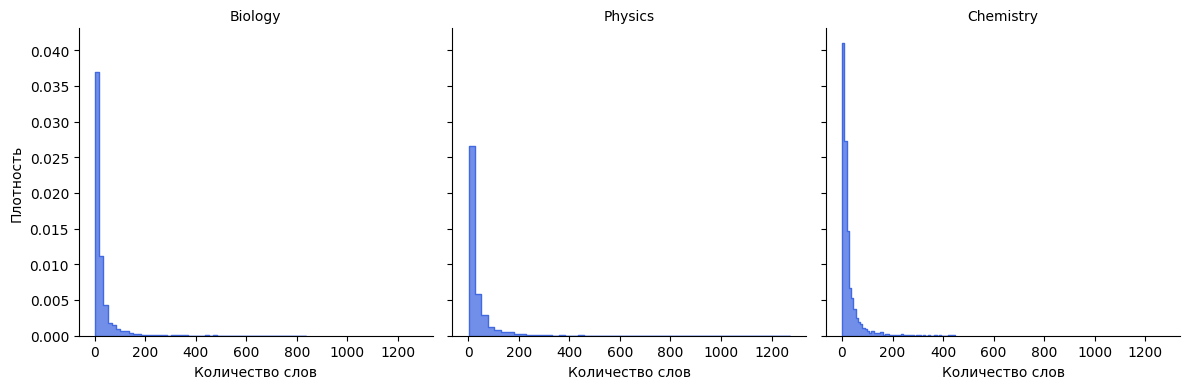

In [ ]:
#Смотрим на распределение количества слов в текстах по группам
g = sns.FacetGrid(df, col="Topic", col_wrap=3, sharex=True, sharey=True, height=4)
g.map(sns.histplot, "n_words", bins=50, element="step", stat="density", color="royalblue")
g.set_titles("{col_name}")
g.set_axis_labels("Количество слов", "Плотность")
plt.show()
#Видим что большинство текстов в каждой группе имеют меньше 100 слов


In [22]:
#Посмотрим на примеры текстов из каждой группы
for lab in df['Topic'].unique():
    print('===', lab, '===\n')
    print(new_df[new_df['Topic']==lab]['Comment'].sample(5, random_state=42).tolist())
    print('\n')


=== Biology ===

['I call them wheel bugs but they are definitely a type of assign bug like previously mentioned', 'Ok but can I drink it anyway? If it’s served cold on a hoy day I probably won’t notice… and I’ll blame the next day diarrhea on the poor choices of snacks I select after the third one…', 'I moved him so he wouldn\'t get squished...he looked at me like he was upset I would do such a thing but, his horn was never close enough to do any "Damage" to me.\\n\\nThanks for all the info!', 'If distilled water is present on both sides then “no” net osmosis occurs. If the solution is different (one side distilled/RO, another including solubles in water or non RO Water) then Osmosis occurs leaving one side with solubles (minerals, etc…) and other side with RO water. Therefore when solubles are left behind there is less water content (on the side that has not yet been filtered). In lamest terms non filtered side has less water content since it’s being cluttered with solubles (minerals

In [ ]:
#Рассмотри самые частовстречающие слова в каждой группе
stop_ru = set(stopwords.words('english'))

def top_n_words(texts, n=40):
    words = []
    for t in texts:
        toks = re.findall(r'\w+', str(t).lower())
        words.extend([w for w in toks if w not in stop_ru])
    return Counter(words).most_common(n)

for lab in new_df['Topic'].unique():
    print('---', lab, '---')
    print(top_n_words(new_df[new_df['Topic']==lab]['Comment'], n=30))


--- Biology ---
[('n', 1161), ('like', 378), ('would', 359), ('one', 331), ('get', 241), ('people', 238), ('think', 211), ('know', 208), ('also', 189), ('could', 177), ('even', 169), ('body', 156), ('much', 154), ('alan', 144), ('really', 141), ('water', 141), ('need', 138), ('well', 132), ('good', 129), ('cells', 126), ('time', 123), ('see', 122), ('life', 121), ('https', 120), ('different', 116), ('way', 116), ('something', 114), ('things', 111), ('species', 108), ('first', 108)]
--- Physics ---
[('n', 1085), ('would', 367), ('time', 244), ('like', 239), ('energy', 228), ('physics', 218), ('think', 199), ('one', 189), ('light', 158), ('also', 153), ('could', 140), ('get', 138), ('see', 138), ('even', 131), ('way', 130), ('force', 130), ('know', 127), ('matter', 125), ('make', 118), ('https', 110), ('data', 107), ('1', 107), ('air', 107), ('quantum', 106), ('really', 101), ('much', 98), ('people', 97), ('good', 97), ('mass', 97), ('speed', 90)]
--- Chemistry ---
[('n', 1014), ('like',

In [ ]:
new_df['Comment'] = new_df['Comment'].astype(str).apply(clean_text)#Очистим текст от ненужным символов и приведём к нижнему регистру

In [34]:
new_df.head(10)

,Id,Comment,Topic,n_chars,n_words
0,0x840,a few things you might have negative frequency...,Biology,1519,254
1,0xbf0,is it so hard to believe that there exist part...,Physics,198,37
2,0xc7e,i m a medication technician and that s alot of...,Biology,187,33
3,0x531,i mean it has some butter but besides that it ...,Chemistry,94,18
4,0x2148,well that s just the thing you can t really in...,Biology,136,21
5,0xc19,is h s what produced when the egg protein is b...,Chemistry,289,52
6,0x2651,and the mrna would have to have a specific pro...,Biology,208,42
7,0xd2,he s probably just really torn up about the dr...,Biology,56,10
8,0x1aab,not free elections but it s what is called a l...,Chemistry,687,80
9,0x27de,this post was brought to you by vinegar it cle...,Biology,57,11


In [ ]:
#Разделим данные на треин валидацию и тест
X = new_df['Comment']
y = new_df['Topic']

X_train, X_tmp, y_train, y_tmp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=SEED
)
X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp, test_size=0.5, stratify=y_tmp, random_state=SEED
)

print(len(X_train), len(X_val), len(X_test))

3804 815 816


In [ ]:

# векторизация (представляем предложение как вектор)
vectorizer = CountVectorizer(ngram_range=(1,2), min_df=3, max_df=0.9)
X_train_vec = vectorizer.fit_transform(X_train)
X_val_vec = vectorizer.transform(X_val)

# модель
model = LogisticRegression(max_iter=1000, random_state=SEED)
model.fit(X_train_vec, y_train)

# предсказания
y_pred = model.predict(X_val_vec)

# оценка
print("F1_macro:", f1_score(y_val, y_pred, average="macro"))
print(classification_report(y_val, y_pred))


F1_macro: 0.6863465477383848
              precision    recall  f1-score   support

     Biology       0.70      0.80      0.75       329
   Chemistry       0.66      0.68      0.67       278
     Physics       0.74      0.57      0.64       208

    accuracy                           0.70       815
   macro avg       0.70      0.68      0.69       815
weighted avg       0.70      0.70      0.69       815



In [234]:
models = [
    ('DummyClassifier', DummyClassifier(random_state=SEED, strategy='most_frequent')),
    ('LogisticRegression', LogisticRegression(random_state=SEED, max_iter=1000, solver='liblinear')),
    ('LinearSVC', LinearSVC(random_state=SEED)),
    ('DecisionTreeClassifier', DecisionTreeClassifier(random_state=SEED, max_depth=4)),
    ('RandomForestClassifier', RandomForestClassifier(random_state=SEED)),
    ('CatBoostClassifier', CatBoostClassifier(random_state=SEED, verbose=0))
]

In [237]:
count_vectorizer_preprocessor = Pipeline([
    ('vec', CountVectorizer(ngram_range=(1,2), min_df=3, max_df=0.9)),
    ('fs', SelectKBest(chi2, k=5000)),  # оставляем 5000 лучших токенов(чтобы модель не учитывала слова которые встречаются везде и не имеют отношения к конкретному контексту)
])

In [205]:
print(helper.train_evaluate_models_cv.__code__.co_filename)



d:\NLP_project\helper.py


c:\Users\dima2\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
c:\Users\dima2\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
c:\Users\dima2\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is depr

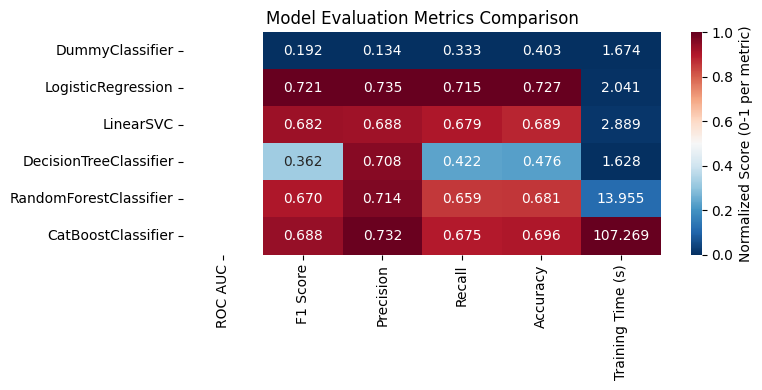

In [270]:
count_vectorizer_metrics = train_evaluate_models_cv_s(
    models=models,
    X=X,
    y=y,
    preprocessor=count_vectorizer_preprocessor,
    cv=5,
    seed=SEED, 
    plot_feature_importance=False
)

In [242]:
count_vectorizer_preprocessor_500 = Pipeline([
    ('vec', CountVectorizer(ngram_range=(1,2), min_df=3, max_df=0.9)),
    ('fs', SelectKBest(chi2, k=500)),  # оставляем 5000 лучших токенов(чтобы модель не учитывала слова которые встречаются везде и не имеют отношения к конкретному контексту)
])

In [ ]:
# создаём pipeline
pipe_fs = Pipeline([
    ('vec', CountVectorizer(ngram_range=(1,2), min_df=3, max_df=0.9)),
    ('fs', SelectKBest(chi2, k=10000)),  # оставляем 5000 лучших токенов(чтобы модель не учитывала слова которые встречаются везде и не имеют отношения к конкретному контексту)
    ('clf', LogisticRegression(max_iter=1000, random_state=SEED))
])

# обучаем
pipe_fs.fit(X_train, y_train)

# предсказываем
y_val_pred = pipe_fs.predict(X_val)

# оцениваем
print("Validation F1_macro:", f1_score(y_val, y_val_pred, average='macro'))
print(classification_report(y_val, y_val_pred))


Validation F1_macro: 0.6783221470765954
              precision    recall  f1-score   support

     Biology       0.70      0.77      0.73       329
   Chemistry       0.65      0.67      0.66       278
     Physics       0.72      0.58      0.64       208

    accuracy                           0.69       815
   macro avg       0.69      0.67      0.68       815
weighted avg       0.69      0.69      0.69       815



In [ ]:
k_values = [500, 1000, 2000, 3000, 5000, 10000]
f1_scores = []

for k in k_values:
    pipe = Pipeline([
        ('vec', CountVectorizer(ngram_range=(1,2), min_df=3, max_df=0.9)),
        ('fs', SelectKBest(chi2, k=k)),
        ('clf', LogisticRegression(max_iter=1000, random_state=SEED))
    ])
    pipe.fit(X_train, y_train)
    y_val_pred = pipe.predict(X_val)
    f1 = f1_score(y_val, y_val_pred, average='macro')
    f1_scores.append(f1)
    print(f"k={k}: F1_macro={f1:.4f}")

k=500: F1_macro=0.6773
k=1000: F1_macro=0.6846
k=2000: F1_macro=0.6730
k=3000: F1_macro=0.6886
k=5000: F1_macro=0.6956
k=10000: F1_macro=0.6783


In [ ]:
#Попробуем LinearSVC вместо линейной регрессии, а также закодировать текст с помощью TfidfVectorizer
k_values = [500, 1000, 2000, 3000, 5000, 10000]
f1_scores = []

for k in k_values:
    pipe_tfidf_svc = Pipeline([
        ('vec', TfidfVectorizer(ngram_range=(1,2), min_df=3, max_df=0.9)),
        ('fs', SelectKBest(chi2, k=k)),
        ('clf', LinearSVC(random_state=SEED))
    ])

    pipe_tfidf_svc.fit(X_train, y_train)
    print(f"k= {k}:","F1_macro:", f1_score(y_val, pipe_tfidf_svc.predict(X_val), average='macro'))


k= 500: F1_macro: 0.682437073097098
k= 1000: F1_macro: 0.6948722164374052
k= 2000: F1_macro: 0.7070290896962476
k= 3000: F1_macro: 0.7112259186669349
k= 5000: F1_macro: 0.721967036113984
k= 10000: F1_macro: 0.7276707719720203


In [ ]:
#Подбор гиперпараметров
grid = {
    'vec__ngram_range': [(1,1), (1,2)],
    'vec__min_df': [2,3,5],
    'fs__k': [2000, 5000, 10000],
    'clf__C': [0.5, 1, 2]
}

pipe = Pipeline([
    ('vec', TfidfVectorizer()),
    ('fs', SelectKBest(chi2)),
    ('clf', LinearSVC(random_state=SEED))
])

gs = GridSearchCV(pipe, grid, scoring='f1_macro', cv=5, n_jobs=-1)
gs.fit(X_train, y_train)

print("Best params:", gs.best_params_)
print("CV best F1:", gs.best_score_)
print("VAL F1:", f1_score(y_val, gs.predict(X_val), average='macro'))


Best params: {'clf__C': 1, 'fs__k': 2000, 'vec__min_df': 2, 'vec__ngram_range': (1, 1)}
CV best F1: 0.7368579239543814
VAL F1: 0.741951443783783


In [ ]:
#Подбор гиперпараметров
pipe = Pipeline([
    ('vec', TfidfVectorizer()),
    ('fs',  SelectKBest(chi2)),
    ('clf', LinearSVC(random_state=SEED))
])

param_grid = {
    'vec__ngram_range': [(1,1), (1,2)],
    'vec__min_df': [2, 3, 5],
    'vec__max_df': [0.9, 1.0],
    'fs__k': [2000, 5000, 10000],
    'clf__C': [0.5, 1, 2],
}

gs = GridSearchCV(
    pipe, param_grid,
    scoring='f1_macro', cv=5, n_jobs=-1, verbose=1
)
gs.fit(X_train, y_train)

print("Best params:", gs.best_params_)
print("CV best F1:", gs.best_score_)
val_f1 = f1_score(y_val, gs.predict(X_val), average='macro')
print("VAL F1:", val_f1)
print("VAL report:\n", classification_report(y_val, gs.predict(X_val)))
best_tfidf_svc = gs.best_estimator_


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best params: {'clf__C': 1, 'fs__k': 2000, 'vec__max_df': 0.9, 'vec__min_df': 2, 'vec__ngram_range': (1, 1)}
CV best F1: 0.7368579239543814
VAL F1: 0.741951443783783
VAL report:
               precision    recall  f1-score   support

     Biology       0.71      0.84      0.77       329
   Chemistry       0.74      0.72      0.73       278
     Physics       0.85      0.63      0.72       208

    accuracy                           0.75       815
   macro avg       0.77      0.73      0.74       815
weighted avg       0.76      0.75      0.75       815



In [ ]:

TfidfVectorizer_preprocessor = Pipeline([
   ('vec', TfidfVectorizer(ngram_range=(1,2), min_df=3, max_df=0.9)),
    ('fs', SelectKBest(chi2, k=5000)),  # оставляем 5000 лучших токенов(чтобы модель не учитывала слова которые встречаются везде и не имеют отношения к конкретному контексту)
])

c:\Users\dima2\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
c:\Users\dima2\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
c:\Users\dima2\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is depr

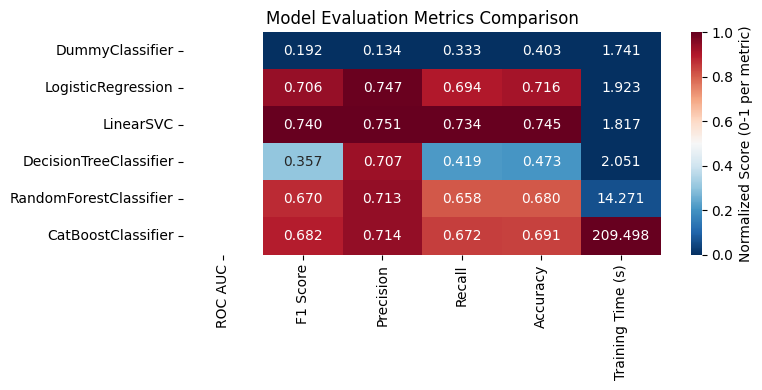

In [247]:
TfidfVectorizer_metrics = train_evaluate_models_cv_s(
    models=models,
    X=X,
    y=y,
    preprocessor=TfidfVectorizer_preprocessor,
    cv=5,
    seed=SEED, 
    plot_feature_importance=False
)

In [271]:
comparison_diff = compare_model_results_simple(
    count_vectorizer_metrics,
    TfidfVectorizer_metrics
)

print(comparison_diff)


                        F1 Score  Precision  Recall  Accuracy
model                                                        
DummyClassifier            0.000      0.000   0.000     0.000
LogisticRegression        -0.016      0.013  -0.021    -0.011
LinearSVC                  0.058      0.063   0.055     0.056
DecisionTreeClassifier    -0.005     -0.002  -0.004    -0.003
RandomForestClassifier    -0.000     -0.002  -0.000    -0.001
CatBoostClassifier        -0.006     -0.018  -0.003    -0.005


In [ ]:
#Закодируем названия топиков как числа чтобы работать с нейросетью
classes = sorted(pd.Series(y_train).unique())
label2id = {c:i for i, c in enumerate(classes)}
y_train_id = np.array([label2id[c] for c in y_train])
y_val_id   = np.array([label2id[c] for c in y_val])
y_test_id  = np.array([label2id[c] for c in y_test])


In [ ]:

vectorizer = layers.TextVectorization(
    max_tokens=30000,
    output_mode="int",
    output_sequence_length=200,
    split="whitespace"
)
vectorizer.adapt(tf.data.Dataset.from_tensor_slices(np.array(X_train)).batch(128))


In [78]:
def build_cnn_model(max_tokens, emb_dim, filters, kernel_sz, drop_rate, num_classes):
    inp = keras.Input(shape=(1,), dtype=tf.string)
    x = vectorizer(inp)
    x = layers.Embedding(input_dim=max_tokens, output_dim=emb_dim)(x)
    x = layers.Conv1D(filters, kernel_sz, padding="same", activation="relu")(x)
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dropout(drop_rate)(x)
    out = layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(inp, out)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

cnn = build_cnn_model(max_tokens=30000, emb_dim=128, filters=256, kernel_sz=5, drop_rate=0.5, num_classes=3)
cnn.summary()


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_1            │ (None, 200)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_6 (Embedding)         │ (None, 200, 128)       │     3,840,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 200, 256)       │       164,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_6          │ (None, 256)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,004,867 (15.28 MB)

 Trainable params: 4,004,867 (15.28 MB)

 Non-trainable params: 0 (0.00 B)

In [79]:
batch_size = 64
epochs = 10

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=2,
        restore_best_weights=True
    )
]

history = cnn.fit(
    x=np.array(X_train),
    y=y_train_id,
    validation_data=(np.array(X_val), y_val_id),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.4040 - loss: 1.0781 - val_accuracy: 0.4258 - val_loss: 1.0548
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.6230 - loss: 0.9446 - val_accuracy: 0.6564 - val_loss: 0.8720
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.8436 - loss: 0.5614 - val_accuracy: 0.7460 - val_loss: 0.6253
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.9385 - loss: 0.2344 - val_accuracy: 0.7571 - val_loss: 0.6304
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.9826 - loss: 0.0903 - val_accuracy: 0.7387 - val_loss: 0.6695


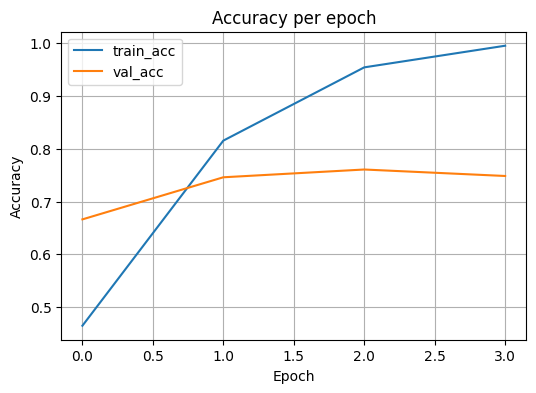

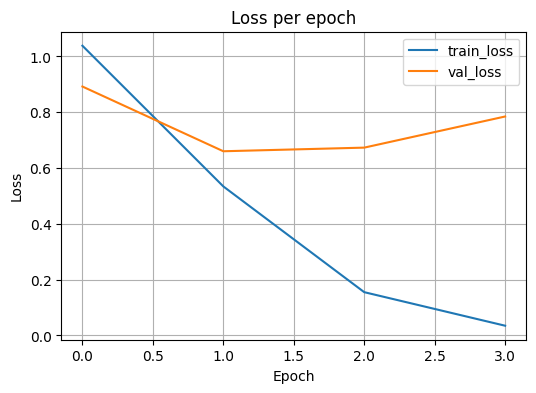

In [71]:


# История доступна в history.history: словарь списков по эпохам
# Обычно ключи: 'loss', 'accuracy', 'val_loss', 'val_accuracy'

plt.figure(figsize=(6,4))
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy per epoch')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per epoch')
plt.legend()
plt.grid(True)
plt.show()


In [80]:


# VAL
y_val_pred = np.argmax(cnn.predict(np.array(X_val), batch_size=128), axis=1)
print("VAL F1_macro:", f1_score(y_val_id, y_val_pred, average="macro"))
print("VAL report:\n", classification_report(y_val_id, y_val_pred))

# TEST
y_test_pred = np.argmax(cnn.predict(np.array(X_test), batch_size=128), axis=1)
print("TEST F1_macro:", f1_score(y_test_id, y_test_pred, average="macro"))
print("TEST report:\n", classification_report(y_test_id, y_test_pred))


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
VAL F1_macro: 0.7377104992523095
VAL report:
               precision    recall  f1-score   support

           0       0.70      0.88      0.78       329
           1       0.76      0.69      0.72       278
           2       0.85      0.61      0.71       208

    accuracy                           0.75       815
   macro avg       0.77      0.73      0.74       815
weighted avg       0.76      0.75      0.74       815

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
TEST F1_macro: 0.7592718241253807
TEST report:
               precision    recall  f1-score   support

           0       0.72      0.85      0.78       329
           1       0.75      0.75      0.75       278
           2       0.89      0.64      0.74       209

    accuracy                           0.76       816
   macro avg       0.79      0.75      0.76       816
weighted avg       0.78      0.76      0.76       816



In [81]:
import numpy as np
from sklearn.metrics import f1_score, classification_report

# VAL
y_val_pred = np.argmax(cnn.predict(np.array(X_val), batch_size=128), axis=1)
print("VAL F1_macro:", f1_score(y_val_id, y_val_pred, average="macro"))
print("VAL report:\n", classification_report(y_val_id, y_val_pred))

# TEST
y_test_pred = np.argmax(cnn.predict(np.array(X_test), batch_size=128), axis=1)
print("TEST F1_macro:", f1_score(y_test_id, y_test_pred, average="macro"))
print("TEST report:\n", classification_report(y_test_id, y_test_pred))


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
VAL F1_macro: 0.7377104992523095
VAL report:
               precision    recall  f1-score   support

           0       0.70      0.88      0.78       329
           1       0.76      0.69      0.72       278
           2       0.85      0.61      0.71       208

    accuracy                           0.75       815
   macro avg       0.77      0.73      0.74       815
weighted avg       0.76      0.75      0.74       815

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
TEST F1_macro: 0.7592718241253807
TEST report:
               precision    recall  f1-score   support

           0       0.72      0.85      0.78       329
           1       0.75      0.75      0.75       278
           2       0.89      0.64      0.74       209

    accuracy                           0.76       816
   macro avg       0.79      0.75      0.76       816
weighted avg       0.78      0.76      0.76       816



In [ ]:


EMB_MODEL_NAME = "all-MiniLM-L6-v2"  
st_model = SentenceTransformer(EMB_MODEL_NAME)


c:\Users\dima2\AppData\Local\Programs\Python\Python313\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\dima2\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not insta

In [85]:


X_train_emb = st_model.encode(list(X_train), batch_size=64, show_progress_bar=True, convert_to_numpy=True, normalize_embeddings=True)
X_val_emb   = st_model.encode(list(X_val),   batch_size=64, show_progress_bar=True, convert_to_numpy=True, normalize_embeddings=True)
X_test_emb  = st_model.encode(list(X_test),  batch_size=64, show_progress_bar=True, convert_to_numpy=True, normalize_embeddings=True)

X_train_emb.shape, X_val_emb.shape, X_test_emb.shape


Batches: 100%|██████████| 13/13 [00:04<00:00,  2.71it/s]


((3804, 384), (815, 384), (816, 384))

In [87]:
# Попробуем LinearSVC (часто лучше на эмбеддингах) и для сравнения LogReg
models = {
    "LinearSVC": (LinearSVC(), {"C":[0.5,1,2,4]}),
    "LogReg": (LogisticRegression(max_iter=2000, n_jobs=-1), {"C":[0.5,1,2,4]})
}

best_name, best_clf, best_val = None, None, -1
for name, (base_clf, grid) in models.items():
    gs = GridSearchCV(base_clf, grid, scoring="f1_macro", cv=5, n_jobs=-1, verbose=0)
    gs.fit(X_train_emb, y_train)
    val_f1 = f1_score(y_val, gs.predict(X_val_emb), average="macro")
    print(f"{name}  best_cv: {gs.best_score_:.4f}  val_f1: {val_f1:.4f}  best_params: {gs.best_params_}")
    if val_f1 > best_val:
        best_val = val_f1
        best_name = name
        best_clf = gs.best_estimator_

print(f"\nЛучший на VAL: {best_name}  F1_macro={best_val:.4f}")
print("\nVAL classification_report:\n", classification_report(y_val, best_clf.predict(X_val_emb)))

LinearSVC  best_cv: 0.7781  val_f1: 0.7599  best_params: {'C': 0.5}
LogReg  best_cv: 0.7831  val_f1: 0.7669  best_params: {'C': 0.5}

Лучший на VAL: LogReg  F1_macro=0.7669

VAL classification_report:
               precision    recall  f1-score   support

     Biology       0.77      0.83      0.80       329
   Chemistry       0.77      0.75      0.76       278
     Physics       0.78      0.71      0.74       208

    accuracy                           0.77       815
   macro avg       0.77      0.76      0.77       815
weighted avg       0.77      0.77      0.77       815



In [88]:
y_test_pred = best_clf.predict(X_test_emb)
print("TEST F1_macro:", f1_score(y_test, y_test_pred, average="macro"))
print("TEST report:\n", classification_report(y_test, y_test_pred))

TEST F1_macro: 0.7974357356481763
TEST report:
               precision    recall  f1-score   support

     Biology       0.81      0.82      0.82       329
   Chemistry       0.76      0.77      0.77       278
     Physics       0.82      0.79      0.81       209

    accuracy                           0.80       816
   macro avg       0.80      0.80      0.80       816
weighted avg       0.80      0.80      0.80       816



In [ ]:

MODEL_NAME = "distilbert-base-uncased" 

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)



# Сборка объектного датасета
ds_train = Dataset.from_dict({"text": list(X_train), "label": y_train_id})
ds_val   = Dataset.from_dict({"text": list(X_val),   "label": y_val_id})
ds_test  = Dataset.from_dict({"text": list(X_test),  "label": y_test_id})

raw_ds = DatasetDict(train=ds_train, validation=ds_val, test=ds_test)

# Токенизация превращаем строки в input_ids/attention_mask
tok_ds = raw_ds.map(tokenize_batch, batched=True, remove_columns=["text"])
tok_ds = tok_ds.with_format("torch")  # PyTorch тензоры
tok_ds


Map: 100%|██████████| 816/816 [00:00<00:00, 12529.98 examples/s]


DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 3804
    })
    validation: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 815
    })
    test: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 816
    })
})

In [93]:
tok_ds["train"][0]


{'label': tensor(2),
 'input_ids': tensor([  101,  1045,  2293,  3666,  2310, 17728,  5332,  2819,  2023,  2003,
          1996,  2087,  2919, 12054,  2518,  1045,  2310,  2464,  3084,  2033,
          2215,  2000,  4553,  2062,  4283,  4942, 11020,  3089, 10472,  2000,
          2008,  7858,   102,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,   

In [97]:
classes = sorted(list(set(y_train)))   # список уникальных меток
label2id = {c: i for i, c in enumerate(classes)}
id2label = {i: c for c, i in label2id.items()}
num_labels = len(classes)


In [ ]:


#Проверяем имена колонок и в случае необходимости меняем
cols = set(tok_ds["train"].column_names)
if "label" in cols and "labels" not in cols:
    tok_ds = tok_ds.rename_column("label", "labels")

tok_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

#Объединяем текста в батчи
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")

train_dl = DataLoader(tok_ds["train"], batch_size=16, shuffle=True,  collate_fn=data_collator)
val_dl   = DataLoader(tok_ds["validation"], batch_size=32, shuffle=False, collate_fn=data_collator)
test_dl  = DataLoader(tok_ds["test"], batch_size=32, shuffle=False, collate_fn=data_collator)


device = torch.device("cpu")  
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)

num_epochs = 3
num_steps = num_epochs * len(train_dl)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=num_steps)#линейнро уменьшаем learning rate

best_val_f1, best_state = -1.0, None
torch.manual_seed(SEED)
np.random.seed(SEED)

#Обучение
for epoch in range(1, num_epochs + 1):
    model.train()
    total_loss = 0.0

    for batch in train_dl:
        batch = {k: v.to(device) for k, v in batch.items()}#переносим весь батч на CPU
        optimizer.zero_grad()#обнуляем старые градиенты
        out = model(**batch) #считает loss сам, т.к. есть labels
        loss = out.loss#средний по батчу loss
        loss.backward()#обратное распространение ошибки, считает градиенты по всем trainable-параметрам.
        optimizer.step()#обновляет веса на основе градиентов
        scheduler.step()#каждый шаг немного уменьшает learning rate
        total_loss += loss.item()#копим суммарный трен-лосс за эпоху (для лога)

    avg_train_loss = total_loss / max(1, len(train_dl))

    #Валидация
    model.eval()
    ys, preds = [], []
    with torch.no_grad():
        for batch in val_dl:
            batch = {k: v.to(device) for k, v in batch.items()}
            labels = batch.pop("labels")
            logits = model(**batch).logits
            pred = torch.argmax(logits, dim=1)
            ys.extend(labels.cpu().numpy().tolist())
            preds.extend(pred.cpu().numpy().tolist())

    val_f1 = f1_score(ys, preds, average="macro")
    print(f"Epoch {epoch} | train_loss={avg_train_loss:.4f} | val_f1={val_f1:.4f}")

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

#ТЕСТ
if best_state is not None:
    model.load_state_dict(best_state)

model.eval()
ys, preds = [], []
with torch.no_grad():
    for batch in test_dl:
        batch = {k: v.to(device) for k, v in batch.items()}
        labels = batch.pop("labels")
        logits = model(**batch).logits
        pred = torch.argmax(logits, dim=1)
        ys.extend(labels.cpu().numpy().tolist())
        preds.extend(pred.cpu().numpy().tolist())
#Вывод результатов
print("TEST F1_macro:", f1_score(ys, preds, average="macro"))
print("TEST report:\n", classification_report(ys, preds, target_names=[id2label[i] for i in range(num_labels)]))


Epoch 1 | train_loss=0.6498 | val_f1=0.7646
Epoch 2 | train_loss=0.3870 | val_f1=0.7900
Epoch 3 | train_loss=0.2777 | val_f1=0.7878
TEST F1_macro: 0.8037939960591894
TEST report:
               precision    recall  f1-score   support

     Biology       0.84      0.84      0.84       329
   Chemistry       0.78      0.74      0.76       278
     Physics       0.79      0.83      0.81       209

    accuracy                           0.81       816
   macro avg       0.80      0.81      0.80       816
weighted avg       0.81      0.81      0.81       816

